# Matrix-vector products with BTTB/BCCB matrices

This notebook illustrates algoritmhs for computing the matrix-vector product for the cases in which the matrix is Block Toeplitz formed by Toeplitz Blocks (BTTB) and Block Circulant formed by Circulant Blocks (BCCB).

#### References

* Davis, P. J. (1979). Circulant matrices, John Wiley & Sons Inc, ISBN 0-471-05771-1

* Jain, A. K. (1989), Fundamentals of Digital Image Processing, Prentice Hall, ISBN 978-0-13-336165-0.

* Horn, R. A. and C. R. Johnson, (1991), Topics in Matrix Analysis, Cambridge University Press, ISBN 978-0-521-46713-1.

* Chan, R. H. and X-Q Jin (2007), An introduction to iterative Toeplitz solvers, Philadelphia: Society for Industrial and Applied Mathematics, ISBN 978-0-898716-36-8.

* Magnus, J. R. and H. Neudecker (2007), Matrix differential calculus with applications in statistics and econometrics, 3rd edition, John Wiley & Sons, ISBN 0-471-98632-1.

* Golub, G. H. and C. F. Van Loan, (2013), Matrix computations, 4th edition, Johns Hopkins University Press, ISBN 978-1-4214-0794-4.

## Topics

* [Block Circulant - Circulant Blocks (BCCB) matrices](#sec1)

    * [BCCB are diagonalized by the Kronecker product of Fourier matrices](#sec1a)
    
    * [The eigenvalues of a BCCB matrix can be computed by the 2D Fourier transform](#sec1b)

    * [Product of $\mathbf{C}_{BCCB}$ and an arbitrary vector $\mathbf{a}$](#sec1c)

* [Block Toeplitz - Toeplitz Blocks (BTTB) matrices](#sec2)

    * [Arbitrary BTTB matrices are not diagonalized by the Kronecker product of Fourier matrices](#sec2a)
    
    * [The Fourier approach used for BCCB matrices is not valid for the product of arbitrary BTTB matrices and arbitrary vectors](#sec2b)
    
    * [The Fourier approach used for BCCB matrices is valid for the product of some particular BTTB matrices and some particular vectors](#sec2c)
   
* [Arbitrary BTTB matrices can be embedded into BCCB matrices](#sec3)

    * [Product of an arbitrary BTTB matrix $\mathbf{T}_{BTTB}$ and an arbitrary vector $\mathbf{b}$](#sec3a)

In [1]:
import numpy as np
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, circulant, dft
from scipy.fft import fft, ifft, fft2, ifft2

<a id='sec1'></a>
## Block Circulant - Circulant Blocks (BCCB) matrices

Let $\mathbf{C}_{BCCB}$ be a BCCB matrix (e.g., Davis, 1979, p. 184; Jain, 1989, p. 28). Such matrices have a $Q \times Q$ circulant block structure formed by $P \times P$ circulant blocks $\mathbf{C}_{q}$, $q = 0, \dots, Q - 1$. For convenience, we represent the elements of a block $\mathbf{C}_{q}$ by $c_{p}^{(q)}$, $p = 0, \dots, P - 1$. The example below illustrates a $\mathbf{C}_{BCCB}$ matrix formed by $Q = 4$ and $P = 3$:

<a id='eq1a'></a>
$$
\mathbf{C}_{BCCB} = \begin{bmatrix}
\mathbf{C}_{0} & \mathbf{C}_{3} & \mathbf{C}_{2} & \mathbf{C}_{1} \\
\mathbf{C}_{1} & \mathbf{C}_{0} & \mathbf{C}_{3} & \mathbf{C}_{2} \\
\mathbf{C}_{2} & \mathbf{C}_{1} & \mathbf{C}_{0} & \mathbf{C}_{3} \\
\mathbf{C}_{3} & \mathbf{C}_{2} & \mathbf{C}_{1} & \mathbf{C}_{0}
\end{bmatrix} \quad , \tag{1a}
$$

where

<a id='eq1b'></a>
$$
\mathbf{C}_{q} = \begin{bmatrix}
c_{0}^{(q)} & c_{2}^{(q)} & c_{1}^{(q)} \\
c_{1}^{(q)} & c_{0}^{(q)} & c_{2}^{(q)} \\
c_{2}^{(q)} & c_{1}^{(q)} & c_{0}^{(q)}
\end{bmatrix} \quad , \quad q = 0, 1, 2, 3 \: . \tag{1b}
$$

In [2]:
Q = 4 # number of blocks along rows/columns
P = 3 # number of rows/columns in each block

In [3]:
# matrix containing the columns of each block
columns = 17*np.random.rand(Q, P) + 3

In [4]:
# create the first column of blocks
column_of_blocks = []
for block_column in columns:
    column_of_blocks.append(circulant(block_column))
column_of_blocks = np.stack(column_of_blocks, axis=0)

In [5]:
# create the BCCB matrix from the first column of blocks
ind_col, ind_row = np.ogrid[0:Q, 0:-Q:-1]
indices = ind_col + ind_row
C_BCCB = np.hstack(np.hstack(column_of_blocks[indices]))

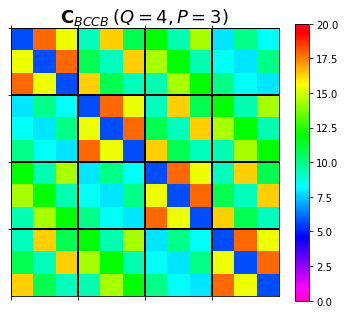

In [6]:
plt.figure(figsize=(6,6))
plt.title('$\mathbf{C}_{BCCB} \: (Q = 4, P = 3)$', fontsize=18)
plt.matshow(C_BCCB, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar(shrink=0.85)
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)
plt.show()

<a id='sec1a'></a>
### BCCB are diagonalized by the Kronecker product of Fourier matrices

It can be shown that the BCCB matrix $\mathbf{C}_{BCCB}$ (equations [1a](#eq1a) and [1b](#eq1b)) is diagonalized by $\left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right)$, where $\mathbf{H}_{Q}$ and $\mathbf{H}_{P}$ are the Fourier matrices of order $Q$ and $P$, respectively. These Fourier matrices are computed with normalization factors $\sqrt{Q}$ and $\sqrt{P}$, so that they are unitary (see the notebook `fourier_1D_4`). It means that $\mathbf{C}_{BCCB}$ satisfies the following equation:

<a id='eq2'></a>
$$
\mathbf{C}_{BCCB} = \left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right)^{\ast}
\boldsymbol{\Lambda}_{BCCB}
\left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \: , \tag{2}
$$

where $\boldsymbol{\Lambda}_{BCCB}$ is a diagonal matrix containing the eigenvalues of $\mathbf{C}_{BCCB}$ and "$\otimes$" denotes the Kronecker product (Jain, 1989; Horn and Johnson, 1991; the notebook `kronecker-product`).

By properly manipulating [equation 2](#eq2), we obtain (Chan and Jin, 2007):

$$
\begin{split}
\left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \mathbf{C}_{BCCB} &= \boldsymbol{\Lambda}_{BCCB} \, \left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \\
\left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \, \mathbf{C}_{BCCB} \, \mathbf{u}_{0} &= \boldsymbol{\Lambda}_{BCCB} \, \left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \, \mathbf{u}_{0} \\
\left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \, \mathbf{c}_{0} &= \boldsymbol{\Lambda}_{BCCB} \, \frac{1}{\sqrt{QP}}\mathbf{1}_{QP}
\end{split} \quad ,
$$

which results in the following equation

<a id='eq3'></a>
$$
\sqrt{QP} \, \left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \, \mathbf{c}_{0} = \boldsymbol{\lambda}_{BCCB} \quad , \tag{3}
$$


where $\mathbf{u}_{0}$ is a $QP \times 1$ vector with the first element equal to $1$ and all the remaining elements equal to $0$, $\mathbf{c}_{0}$ is the first column of $\mathbf{C}_{BTTB}$, $\mathbf{1}_{QP}$ is a $QP \times 1$ with all elements equal to $1$ and $\boldsymbol{\lambda}_{BTTB}$ is the vector forming the diagonal of $\boldsymbol{\Lambda}_{BTTB}$ (the eigenvalues of $\mathbf{C}_{BTTB}$).

[Equation 3](#eq3) shows that the eigenvalues of $\mathbf{C}_{BTTB}$ from its first column.

In [7]:
# scale must be sqrt(n) for DFT be unitary
HQ = dft(n=Q, scale='sqrtn')
HP = dft(n=P, scale='sqrtn')

In [8]:
# compute the Kronecker product
HQ_kron_HP = np.kron(HQ, HP)

In [9]:
# compute the eigenvalues of C_BCCB
lambda_BCCB = np.sqrt(Q*P)*np.dot(HQ_kron_HP, C_BCCB[:,0])

In [10]:
# create matrix Lambda_BCCB
Lambda_BCCB = np.diag(lambda_BCCB)

In [11]:
# compute a BCCB matrix C2 by evaluating the right side of equation 2
C2 = multi_dot([np.conj(HQ_kron_HP), Lambda_BCCB, HQ_kron_HP])

In [12]:
# verify that C_BCCB and C2 are equal to each other
np.allclose(C_BCCB, C2)

True

<a id='sec1b'></a>
### The eigenvalues of a BCCB matrix can be computed by the 2D Fourier transform

By using the Kronecker product (see equations 3 and 4 of the notebook `kronecker-product`) and the symmetry of Fourier matrices, [equation 3](#eq3) can be rewritten as follows:

<a id='eq4a'></a>
$$
\sqrt{QP} \; \mathbf{H}_{Q} \, \mathbf{G}_{row} \, \mathbf{H}_{P} = \mathbf{L}_{row} \: , \tag{4a}
$$

where $\mathbf{G}_{row}$ and $\mathbf{L}_{row}$ are $Q \times P$ matrices obtained, respectively, by reorganizing the vectors $\mathbf{c}_{0}$ and $\boldsymbol{\lambda}_{BCCB}$ along their rows (Jain, 1989; Horn and Johnson, 1991).
Alternatively, [equation 3](#eq3) can be rewritten as follows (see equations 5 and 6 of the notebook `kronecker-product`):

<a id='eq4b'></a>
$$
\sqrt{QP} \; \mathbf{H}_{P} \, \mathbf{G}_{col} \, \mathbf{H}_{Q} = \mathbf{L}_{col} \: , \tag{4b}
$$

where $\mathbf{G}_{col}$ and $\mathbf{L}_{col}$ are $P \times Q$ matrices obtained, respectively, by reorganizing the vectors $\mathbf{c}_{0}$ and $\boldsymbol{\lambda}_{BCCB}$ along their columns (Magnus and Neudecker, 2007).


Equations [4a](#eq4a) and [4b](#eq4b) show that the eigenvalues of $\mathbf{C}_{BCCB}$ can be computed from the 2D DFT of its first column $\mathbf{c}_{0}$ (see the notebook `fourier_2D`).

In [13]:
L_row = np.reshape(lambda_BCCB, (Q, P))

In [14]:
G_row = np.reshape(C_BCCB[:,0], (Q, P))

In [15]:
np.allclose(np.sqrt(Q*P)*multi_dot([HQ, G_row, HP]), L_row)

True

In [16]:
np.allclose(np.sqrt(Q*P)*fft2(x=G_row, norm='ortho'), L_row)

True

In [17]:
L_col = np.reshape(lambda_BCCB, (Q, P)).T

In [18]:
np.allclose(L_col, L_row.T)

True

In [19]:
G_col = np.reshape(C_BCCB[:,0], (Q, P)).T

In [20]:
np.allclose(G_col, G_row.T)

True

In [21]:
np.allclose(np.sqrt(Q*P)*multi_dot([HP, G_col, HQ]), L_col)

True

In [22]:
np.allclose(np.sqrt(Q*P)*fft2(x=G_col, norm='ortho'), L_col)

True

<a id='sec1c'></a>
### Product of $\mathbf{C}_{BCCB}$ and an arbitrary vector $\mathbf{a}$

Let's consider the following matrix-vector product:

<a id='eq5'></a>
$$
\mathbf{C}_{BCCB} \; \mathbf{a} = \mathbf{w} \: , \tag{5}
$$

where $\mathbf{a}$ and $\mathbf{w}$ are $QP \times 1$ vectors and $\mathbf{C}_{BCCB}$ is an arbitrary $QP \times QP$ BCCB matrix. By using [equation 2](#eq2), we can rewrite [equation 5](#eq5) and obtain 

<a id='eq6'></a>
$$
\left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right)^{\ast} \boldsymbol{\Lambda}_{BCCB} \left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \mathbf{a} = \mathbf{w} \: . \tag{6}
$$

Remember that $\boldsymbol{\Lambda}_{BCCB}$ is a diagonal matrix with diagonal defined by the vector $\boldsymbol{\lambda}_{BCCB}$ ([equation 3](#eq3)). Consequently, we can rewrite [equation 6](#eq6) according to:

<a id='eq7a'></a>
$$
\left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right)^{\ast} \mathbf{h}
 = \mathbf{w} \: , \tag{7a}
$$

where $\mathbf{h}$ is a $QP \times 1$ vector given by

<a id='eq7b'></a>
$$
\mathbf{h} = \boldsymbol{\lambda}_{BCCB} \circ \left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \mathbf{a} \tag{7b}
$$

and "$\circ$" denotes the Hadamard product.

By using the Kronecker product (see equations 3 and 4 of the notebook `kronecker-product`), we can transform equations [7a](#eq7a) and [7b](#eq7b) into:

<a id='eq8a'></a>
$$
\mathbf{H}_{Q}^{\ast} \, \mathbf{H}_{row} \, \mathbf{H}_{P}^{\ast} = \mathbf{W}_{row} \tag{8a}
$$

and

<a id='eq8b'></a>
$$
\mathbf{H}_{row} = \mathbf{L}_{row} \circ \left( \mathbf{H}_{Q} \mathbf{A}_{row} \, \mathbf{H}_{P} \right) \quad , \tag{8b}
$$

where $\mathbf{H}_{row}$, $\mathbf{W}_{row}$ and $\mathbf{A}_{row}$ are $Q \times P$ matrices obtained by reorganizing, respectively, the vectors $\mathbf{h}$ ([equation 7b](#eq7b)), $\mathbf{a}$ and $\mathbf{w}$ ([equation 5](#eq5)) along their rows and $\mathbf{L}_{row}$ is defined by [equation 4a](#eq4a). By combining equations [8a](#eq8a) and [8b](#eq8b), we obtain 

<a id='eq8c'></a>
$$
\mathbf{H}_{Q}^{\ast} \left[ \mathbf{L}_{row} \circ \left( \mathbf{H}_{Q} \mathbf{A}_{row} \, \mathbf{H}_{P} \right) \right] \mathbf{H}_{P}^{\ast} = \mathbf{W}_{row} \: . \tag{8c}
$$

Alternatively, we can transform equations [7a](#eq7a) and [7b](#eq7b) into (see equations 5 and 6 of the notebook `kronecker-product`):

<a id='eq9a'></a>
$$
\mathbf{H}_{P}^{\ast} \, \mathbf{H}_{col} \, \mathbf{H}_{Q}^{\ast} = \mathbf{W}_{col} \tag{9a}
$$

and

<a id='eq9b'></a>
$$
\mathbf{H}_{col} = \mathbf{L}_{col} \circ \left( \mathbf{H}_{P} \mathbf{A}_{col} \, \mathbf{H}_{Q} \right) \quad , \tag{9b}
$$

where $\mathbf{H}_{col}$, $\mathbf{W}_{col}$ and $\mathbf{A}_{col}$ are $P \times Q$ matrices obtained by reorganizing, respectively, the vectors $\mathbf{h}$ ([equation 7b](#eq7b)), $\mathbf{a}$ and $\mathbf{w}$ ([equation 5](#eq5)) along their columns and $\mathbf{L}_{col}$ is defined by [equation 4b](#eq4b). By combining equations [9a](#eq9a) and [9b](#eq9b), we obtain 

<a id='eq9c'></a>
$$
\mathbf{H}_{P}^{\ast} \left[ \mathbf{L}_{col} \circ \left( \mathbf{H}_{P} \mathbf{A}_{col} \, \mathbf{H}_{Q} \right) \right] \mathbf{H}_{Q}^{\ast} = \mathbf{W}_{col} \: . \tag{9c}
$$

It is worth noting that matrix $\mathbf{W}_{row}$ ([equation 8a](#eq8a)), which contain the elements of vector $\mathbf{w}$ ([equation 5](#eq5)), is the 2D IDFT of the Hadamard product of the matrix $\mathbf{L}_{row}$ ([equation 4a](#eq4a)), which contains the eigenvalues of the BCCB matrix $\mathbf{C}_{BCCB}$ ([equation 5](#eq5)), and the 2D DFT of the matrix $\mathbf{A}_{row}$, which contains the elements of vector $\mathbf{a}$ ([equation 5](#eq5)). Similarly, matrix $\mathbf{W}_{col}$ ([equation 9a](#eq9a)), which contain the elements of vector $\mathbf{w}$ ([equation 5](#eq5)), is the 2D IDFT of the Hadamard product of the matrix $\mathbf{L}_{col}$ ([equation 4b](#eq4b)), which contains the eigenvalues of the BCCB matrix $\mathbf{C}_{BCCB}$ ([equation 5](#eq5)), and the 2D DFT of the matrix $\mathbf{A}_{col}$, which contains the elements of vector $\mathbf{a}$ ([equation 5](#eq5)). Equations [8c](#eq8c) and [9c](#eq9c) show that the matrix-vector product of a BCCB matrix and an arbitrary vector can be computed by using the 2D DFT.

In [23]:
# create an arbitrary vector a
a = np.random.rand(Q*P)

In [24]:
# compute a vector w by using equation 5
w = np.dot(C_BCCB, a)

In [25]:
# reorganize w along the lines of a Q x P matrix W
W_row = np.reshape(w, (Q, P))

In [26]:
# reorganize a along the lines of a Q x P matrix A
A_row = np.reshape(a, (Q, P))

In [27]:
# compute matrix H by using equation 8b
H_row = L_row*fft2(x=A_row, norm='ortho')

In [28]:
# compute a matrix W2 by using equation 8a
W_row2 = ifft2(x=H_row, norm='ortho')

In [29]:
# compare matrices W and W2
np.allclose(W_row, W_row2)

True

In [30]:
# reorganize w along the columns of a P x Q matrix W
W_col = np.reshape(w, (Q, P)).T

In [31]:
# reorganize a along the lines of a P x Q matrix A
A_col = np.reshape(a, (Q, P)).T

In [32]:
# compute matrix H by using equation 9b
H_col = L_col*fft2(x=A_col, norm='ortho')

In [33]:
# compute a matrix W2 by using equation 9a
W_col2 = ifft2(x=H_col, norm='ortho')

In [34]:
# compare matrices W and W2
np.allclose(W_col, W_col2)

True

In [35]:
np.allclose(W_col, W_row.T)

True

<a id='sec2'></a>
## Block Toeplitz - Toeplitz Block (BTTB) matrices

Let $\mathbf{T}_{BTTB}$ be a BTTB matrix (e.g., Jain, 1989, p. 28; Chan and Jin, 2007, p. 67). Such matrices have a $Q \times Q$ Toeplitz block structure formed by $P \times P$ Toeplitz blocks $\mathbf{T}_{q}$, $q = -Q + 1, \dots, Q - 1$. For convenience, we represent the elements of a block $\mathbf{T}_{q}$ by $t_{p}^{(q)}$, $p = -P + 1, \dots, P - 1$. The example below illustrates a $\mathbf{T}_{BTTB}$ matrix formed by $Q = 4$ and $P = 3$:

<a id='eq10a'></a>
$$
\mathbf{T}_{BTTB} = \begin{bmatrix}
\mathbf{T}_{0} & \mathbf{T}_{1} & \mathbf{T}_{2} & \mathbf{T}_{3} \\
\mathbf{T}_{-1} & \mathbf{T}_{0} & \mathbf{T}_{1} & \mathbf{T}_{2} \\
\mathbf{T}_{-2} & \mathbf{T}_{-1} & \mathbf{T}_{0} & \mathbf{T}_{1} \\
\mathbf{T}_{-3} & \mathbf{T}_{-2} & \mathbf{T}_{-1} & \mathbf{T}_{0}
\end{bmatrix} \quad , \tag{10a}
$$

where

<a id='eq10b'></a>
$$
\mathbf{T}_{q} = \begin{bmatrix}
t_{0}^{(q)} & t_{2}^{(q)} & t_{1}^{(q)} \\
t_{-1}^{(q)} & t_{0}^{(q)} & t_{2}^{(q)} \\
t_{-2}^{(q)} & t_{-1}^{(q)} & t_{0}^{(q)}
\end{bmatrix} \quad , \quad q = -3, \dots, 3 \: . \tag{10b}
$$

In [ ]:
Q = 4 # number of blocks along rows/columns
P = 3 # number of rows/columns in each block

In [ ]:
# matrix containing the columns of each block
columns = 17*np.random.rand(2*Q -1, P) + 3
rows = 17*np.random.rand(2*Q - 1, P) + 3

In [ ]:
# create a list of blocks 
list_of_blocks = []
for block_column, block_row in zip(columns, rows):
    list_of_blocks.append(toeplitz(block_column, block_row))
list_of_blocks = np.stack(list_of_blocks, axis=0)

In [ ]:
# create the BCCB matrix from the list of blocks
ind_col, ind_row = np.ogrid[0:Q, Q-1:-1:-1]
indices = ind_col + ind_row
T_BTTB = np.hstack(np.hstack(list_of_blocks[indices]))

In [ ]:
plt.figure(figsize=(6,6))
plt.title('$\mathbf{T}_{BTTB} \: (Q = 4, P = 3)$', fontsize=18)
plt.matshow(T_BTTB, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar(shrink=0.85)
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)
plt.show()

<a id='sec2a'></a>
### Arbitrary BTTB matrices are not diagonalized by the Kronecker product of Fourier matrices

Differently from BCCB matrices (equation [1a](#eq1a) and [1b](#eq1b)), arbitrary BTTB matrices $\mathbf{T}_{BTTB}$ are not diagonalized by the matrix $\left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right)$. It means that we cannot write an [equation 2](#eq2) for the BTTB matrix $\mathbf{T}_{BTTB}$, in which the elements of a diagonal matrix $\boldsymbol{\Lambda}_{BTTB}$ are obtained by computing the Fourier transform of the first column of $\mathbf{T}_{BTTB}$, according to equations [3](#eq3), [4a](#eq4a) or [4b](#eq4b). In order to illustrate this issue, consider the matrix $\mathbf{T}_{BTTB}^{\prime}$ given by:

<a id='eq11'></a>
$$
\mathbf{T}_{BTTB}^{\prime} = \left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right)^{\ast} \, \boldsymbol{\Lambda}_{BTTB}^{\prime} \, \left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \: , \tag{11}
$$

where $\boldsymbol{\Lambda}_{BTTB}^{\prime}$ is a diagonal matrix. Besides, consider that the diagonal of $\boldsymbol{\Lambda}_{BTTB}^{\prime}$ is defined by the vector $\boldsymbol{\lambda}_{BTTB}^{\prime}$:

<a id='eq12'></a>
$$
\boldsymbol{\lambda}_{BTTB}^{\prime} = \sqrt{QP} \, \left( \mathbf{H}_{Q} \otimes \mathbf{H}_{P} \right) \, \mathbf{t}_{0} \quad , \tag{12}
$$

where $\mathbf{t}_{0}$ is the first column of the $QP \times QP$ BTTB matrix $\mathbf{T}_{BTTB}$. The cells below show that matrix $\mathbf{T}_{BTTB}^{\prime}$ is different from the BTTB matrix $\mathbf{T}_{BTTB}$.

In [ ]:
# scale must be sqrt(n) for DFT be unitary
HQ = dft(n=Q, scale='sqrtn')
HP = dft(n=P, scale='sqrtn')

In [ ]:
# compute the Kronecker product
HQ_kron_HP = np.kron(HQ, HP)

In [ ]:
# compute the eigenvalues of lambda_BTTB_prime (equation 12)
lambda_BTTB_prime = np.sqrt(Q*P)*np.dot(HQ_kron_HP, T_BTTB[:,0])

In [ ]:
# create matrix Lambda_BTTB_prime (equation 11)
Lambda_BTTB_prime = np.diag(lambda_BTTB_prime)

In [ ]:
# compute the matrix T_BTTB_prime according to equation 11
T_BTTB_prime = multi_dot([np.conj(HQ_kron_HP), Lambda_BTTB_prime, HQ_kron_HP]).real

In [ ]:
# verify that T_BTTB and T_BTTB_prime are equal to each other
np.allclose(T_BTTB, T_BTTB_prime)

The cell above shows that $\mathbf{T}_{BTTB} \ne \mathbf{T}_{BTTB}^{\prime}$.

In [ ]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.subplot(121)
plt.title('$\mathbf{T}_{BTTB}$', fontsize=18)
plt.matshow(T_BTTB, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.title('$\mathbf{T}_{BTTB}^{\prime}$', fontsize=18)
plt.matshow(T_BTTB_prime, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

<a id='sec2b'></a>
### The Fourier approch used for BCCB matrices is not valid for the product of arbitrary BTTB matrices and arbitrary vectors

The cells above show that, for arbitrary BTTB matrices $\mathbf{T}_{BTTB}$ and vectors $\mathbf{a}$, 

$$
\mathbf{T}_{BTTB} \, \mathbf{a} \ne \mathbf{T}_{BTTB}^{\prime} \, \mathbf{a} \: ,
$$

where $\mathbf{T}_{BTTB}^{\prime}$ is defined by equations [11](#eq11) and [12](#eq12). This implies that, for arbitrary BTTB matrices $\mathbf{T}_{BTTB}$ and vectors $\mathbf{a}$, we cannot compute the product $\mathbf{T}_{BTTB} \, \mathbf{a}$ via 2D Fourier transform by using the same approach for BCCB matrices (equations [5](#eq5)-[9](#eq9)).

In [ ]:
# create a vector a
a = np.random.rand(Q*P)

In [ ]:
# product of T_BTTB and this vector a
T_BTTB_a = np.dot(T_BTTB, a)

In [ ]:
# product of T_BTTB' and vector a
T_BTTB_prime_a = np.dot(T_BTTB_prime, a)

In [ ]:
# notice that they are not the same
np.allclose(T_BTTB_a, T_BTTB_prime_a)

<a id='sec2c'></a>
### The Fourier approch used for BCCB matrices is valid for the product of some particular BTTB matrices and some particular vectors

For some particular BTTB matrices $\mathbf{T}_{BTTB}$ and some particular vectors $\mathbf{a}$, the same approach defined by equations [5](#eq5)-[9](#eq9) for BCCB matrices can be used to compute the product $\mathbf{T}_{BTTB} \, \mathbf{a}$. 

These particular BTTB matrices $\mathbf{T}_{BTTB}$ and vectors $\mathbf{a}$ must satisfy the following conditions:

* Matrix $\mathbf{T}_{BTTB}$ must be block lower triangular;
* All blocks $\mathbf{T}_{q}$ must be lower triangular;
* The last $Q-Q_{1}$ blocks $\mathbf{T}_{q}$ (with $Q_{1} < Q$) in the first block column must be formed by null elements;
* The last $P-P_{1}$ elements of $\mathbf{t}^{(q)}_{0} \equiv \mathbf{T}_{q}[: \, , \, 0]$ (with $P_{1} < P$) of each block must be equal to zero;
* Vector $\mathbf{a}$ must be formed by stacking $Q$ $P \times 1$ vectors $\mathbf{a}_{q}$;
* The last $Q_{1}$ vectors $\mathbf{a}_{q}$ (with $Q_{1} < Q$) must be formed by null elements;
* The last $P_{1}$ elements (with $P_{1} < P$) of all vectors $\mathbf{a}_{q}$ must be equal to zero.

If $\mathbf{T}_{BTTB}$ and $\mathbf{a}$ satisfy the above conditions, the matrix $\mathbf{T}_{BTTB}^{\prime}$ satisfies the following conditions:

* $\mathbf{T}_{BTTB}^{\prime} \ne \mathbf{T}_{BTTB}$;
* $\mathbf{T}_{BTTB}^{\prime} \, \mathbf{a} = \mathbf{T}_{BTTB} \, \mathbf{a}$  .

In [ ]:
Q = 7 # number of blocks along rows/columns
P = 5 # number of rows/columns in each block

In [ ]:
Q1 = 3 
P1 = 3

In [ ]:
# matrices containing the columns/rows of each block
columns = 17*np.random.rand(2*Q -1, P) + 3
columns[:Q-1] = 0 # fill the row blocks with zeros
columns[Q-1 + Q1:] = 0 # 
for i in range(Q-1, Q-1 + Q1):
    columns[i][P1:] = 0
rows = np.zeros((2*Q - 1, P))

In [ ]:
# create a list of blocks 
list_of_blocks = []
for block_column, block_row in zip(columns, rows):
    list_of_blocks.append(toeplitz(block_column, block_row))
list_of_blocks = np.stack(list_of_blocks, axis=0)

In [ ]:
# create the BTTB matrix from the list of blocks
ind_col, ind_row = np.ogrid[0:Q, Q-1:-1:-1]
indices = ind_col + ind_row
T_BTTB = np.hstack(np.hstack(list_of_blocks[indices]))

In [ ]:
# vector a satisfying the conditions above
a = []
for i in range(Q - Q1):
    a.append(np.hstack([17*np.random.rand(P-P1) + 3, np.zeros(P1)]))
for i in range(Q1):
    a.append(np.zeros(P))
a = np.hstack(a)

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.title('$\mathbf{T}_{BTTB}$', fontsize=18)
plt.matshow(T_BTTB, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(1,2,2)
plt.title('$\mathbf{a}$', fontsize=18)
plt.matshow(np.reshape(a, (a.size,1)), fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[0.5], labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

In [ ]:
# scale must be sqrt(n) for DFT be unitary
HQ = dft(n=Q, scale='sqrtn')
HP = dft(n=P, scale='sqrtn')

In [ ]:
# compute the Kronecker product
HQ_kron_HP = np.kron(HQ, HP)

In [ ]:
# compute the eigenvalues of lambda_BTTB_prime (equation 12)
lambda_BTTB_prime = np.sqrt(Q*P)*np.dot(HQ_kron_HP, T_BTTB[:,0])

In [ ]:
# create matrix Lambda_BTTB_prime (equation 11)
Lambda_BTTB_prime = np.diag(lambda_BTTB_prime)

In [ ]:
# compute the matrix T_BTTB_prime according to equation 11
T_BTTB_prime = multi_dot([np.conj(HQ_kron_HP), Lambda_BTTB_prime, HQ_kron_HP]).real

In [ ]:
# verify that T_BTTB and T_BTTB_prime are not equal to each other
np.allclose(T_BTTB, T_BTTB_prime)

In [ ]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

plt.subplot(121)
plt.title('$\mathbf{T}_{BTTB}$', fontsize=18)
plt.matshow(T_BTTB, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.title('$\mathbf{T}_{BTTB}^{\prime}$', fontsize=18)
plt.matshow(T_BTTB_prime, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

The differences between $\mathbf{T}_{BTTB}$ and $\mathbf{T}_{BTTB}^{\prime}$ are concentrated at the blocks located at the upper right corner and at the upper right corner of each non-null block. The remaining parts of these matrices are equal to each other. These differences, however, coincide with the null elements of $\mathbf{a}$. As a consequence:

$$
\mathbf{T}_{BTTB} \, \mathbf{a} = \mathbf{T}_{BTTB}^{\prime} \, \mathbf{a} \: .
$$

In [ ]:
# product of T_BTTB and this vector a
w = np.dot(T_BTTB, a)

In [ ]:
# product of T_BTTB' and vector a
w2 = np.dot(T_BTTB_prime, a)

In [ ]:
# notice that they are not the same
np.allclose(w, w2)

In this case, we can also use the approach defined by equations [5](#eq5)-[9](#eq9) to compute the product $\mathbf{T}_{BTTB} \, \mathbf{a}$ involving the particular BTTB matrix $\mathbf{T}_{BTTB}$ and vector $\mathbf{a}$:

In [ ]:
# reorganize w along the lines of a Q x P matrix W
W = np.reshape(w, (Q, P))

In [ ]:
# reorganize lambda_BTTB_prime along the lines of a Q x P matrix L
L = np.reshape(lambda_BTTB_prime, (Q, P))

In [ ]:
# reorganize a along the lines of a Q x P matrix A
A = np.reshape(a, (Q, P))

In [ ]:
# compute matrix H by using equation 8b
H = L*fft2(x=A, norm='ortho')

In [ ]:
# compute a matrix W2 by using equation 8a
W2 = ifft2(x=H, norm='ortho')

In [ ]:
# compare matrices W and W2
np.allclose(W, W2)

<a id='sec3'></a>
## Arbitrary BTTB matrices can be embedded into BCCB matrices

Any $QP \times QP$ BTTB matrix $\mathbf{T}_{BTTB}$ can be embedded into a $4QP \times 4QP$ BCCB matrix $\mathbf{C}_{BCCB}$. The embedding matrix $\mathbf{C}_{BCCB}$ is formed by a $2Q \times 2Q$ grid of blocks $\mathbf{C}_{q}$, $q = -Q + 1, \dots, Q - 1$.

The first block column of $\mathbf{C}_{BCCB}$ is given by:

<a id='eq13'></a>
$$
\mathbf{C}^{(0)} = \begin{bmatrix}
\mathbf{C}_{0} \\
\mathbf{C}_{-1} \\
\vdots \\
\mathbf{C}_{-Q+1} \\
\mathbf{0} \\
\mathbf{C}_{Q-1} \\
\mathbf{C}_{Q-2} \\
\vdots \\
\mathbf{C}_{1}
\end{bmatrix} \: , \tag{13}
$$

where $\mathbf{0}$ is a $2P \times 2P$ matrix of zeros. The remaining block columns of $\mathbf{C}_{BCCB}$ are obtained by properly down-shifting the blocks along the first block column $\mathbf{C}^{(0)}$ (Golub and Van Loan, 2013).

Each block $\mathbf{C}_{q}$, $q = -Q + 1, \dots, Q - 1$, is a $2P \times 2P$ circulant matrix obtained by reorganizing the elements of each Toeplitz block of $\mathbf{T}_{BTTB}$. The first column $\mathbf{c}^{(q)}_{0}$ of $\mathbf{C}_{q}$ is given by:

<a id='eq14'></a>
$$
\mathbf{c}^{(q)}_{0} = \begin{bmatrix}
t_{0}^{(q)} \\
t_{-1}^{(q)} \\
\vdots \\
t_{-P+1}^{(q)} \\
0 \\
t_{P-1}^{(q)} \\
t_{P-2}^{(q)} \\
\vdots \\
t_{1}^{(q)}
\end{bmatrix} \: , \tag{14}
$$

where $t_{p}^{(q)}$, $p = -P + 1, \dots, P - 1$, are the elements of the block $q$ forming the BTTB matrix $\mathbf{T}_{BTTB}$. The remaining columns of $\mathbf{C}_{q}$ are generated by properly down-shifting the elements of $\mathbf{c}^{(q)}_{0}$ (Golub and Van Loan, 2013).

Consider the BTTB matrix $\mathbf{T}_{BTTB}$ defined by [equation 10a](#eq10a), with blocks $\mathbf{T}_{q}$ defined by [equation 10b](#eq10b). The embedding matrix $\mathbf{C}_{BCCB}$, in this case, is given by:

<a id='eq15a'></a>
$$
\mathbf{C}_{BCCB} = \begin{bmatrix}
\mathbf{C}_{ 0} & \mathbf{C}_{ 1} & \mathbf{C}_{ 2} & \mathbf{C}_{ 3} & \mathbf{0}      & \mathbf{C}_{-3} & \mathbf{C}_{-2} & \mathbf{C}_{-1} \\
\mathbf{C}_{-1} & \mathbf{C}_{ 0} & \mathbf{C}_{ 1} & \mathbf{C}_{ 2} & \mathbf{C}_{ 3} & \mathbf{0}      & \mathbf{C}_{-3} & \mathbf{C}_{-2} \\
\mathbf{C}_{-2} & \mathbf{C}_{-1} & \mathbf{C}_{ 0} & \mathbf{C}_{ 1} & \mathbf{C}_{ 2} & \mathbf{C}_{ 3} & \mathbf{0}      & \mathbf{C}_{-3} \\
\mathbf{C}_{-3} & \mathbf{C}_{-2} & \mathbf{C}_{-1} & \mathbf{C}_{ 0} & \mathbf{C}_{ 1} & \mathbf{C}_{ 2} & \mathbf{C}_{ 3} & \mathbf{0}     \\
\mathbf{0}      & \mathbf{C}_{-3} & \mathbf{C}_{-2} & \mathbf{C}_{-1} & \mathbf{C}_{ 0} & \mathbf{C}_{ 1} & \mathbf{C}_{ 2} & \mathbf{C}_{ 3} \\
\mathbf{C}_{ 3} & \mathbf{0}      & \mathbf{C}_{-3} & \mathbf{C}_{-2} & \mathbf{C}_{-1} & \mathbf{C}_{ 0} & \mathbf{C}_{ 1} & \mathbf{C}_{ 2} \\
\mathbf{C}_{ 2} & \mathbf{C}_{ 3} & \mathbf{0}      & \mathbf{C}_{-3} & \mathbf{C}_{-2} & \mathbf{C}_{-1} & \mathbf{C}_{ 0} & \mathbf{C}_{ 1} \\
\mathbf{C}_{ 1} & \mathbf{C}_{ 2} & \mathbf{C}_{ 3} & \mathbf{0}      & \mathbf{C}_{-3} & \mathbf{C}_{-2} & \mathbf{C}_{-1} & \mathbf{C}_{ 0} \\
\end{bmatrix} \: , \tag{15a}
$$

with blocks

<a id='eq15b'></a>
$$
\mathbf{C}_{q} = \begin{bmatrix}
t^{(q)}_{ 0} & t^{(q)}_{ 1} & t^{(q)}_{ 2} & t^{(q)}_{ 3} & 0      & t^{(q)}_{-3} & t^{(q)}_{-2} & t^{(q)}_{-1} \\
t^{(q)}_{-1} & t^{(q)}_{ 0} & t^{(q)}_{ 1} & t^{(q)}_{ 2} & t^{(q)}_{ 3} & 0      & t^{(q)}_{-3} & t^{(q)}_{-2} \\
t^{(q)}_{-2} & t^{(q)}_{-1} & t^{(q)}_{ 0} & t^{(q)}_{ 1} & t^{(q)}_{ 2} & t_{ 3} & 0      & t^{(q)}_{-3} \\
t^{(q)}_{-3} & t^{(q)}_{-2} & t^{(q)}_{-1} & t^{(q)}_{ 0} & t^{(q)}_{ 1} & t^{(q)}_{ 2} & t^{(q)}_{ 3} & 0     \\
0      & t^{(q)}_{-3} & t^{(q)}_{-2} & t^{(q)}_{-1} & t^{(q)}_{ 0} & t^{(q)}_{ 1} & t^{(q)}_{ 2} & t^{(q)}_{ 3} \\
t^{(q)}_{ 3} & 0      & t^{(q)}_{-3} & t^{(q)}_{-2} & t^{(q)}_{-1} & t_{ 0} & t^{(q)}_{ 1} & t^{(q)}_{ 2} \\
t^{(q)}_{ 2} & t^{(q)}_{ 3} & 0      & t^{(q)}_{-3} & t^{(q)}_{-2} & t_{-1} & t^{(q)}_{ 0} & t^{(q)}_{ 1} \\
t^{(q)}_{ 1} & t^{(q)}_{ 2} & t^{(q)}_{ 3} & 0      & t^{(q)}_{-3} & t_{-2} & t^{(q)}_{-1} & t^{(q)}_{ 0} \\
\end{bmatrix} \: . \tag{15b}
$$

In [ ]:
Q = 4 # number of blocks along rows/columns
P = 3 # number of rows/columns in each block

In [ ]:
# matrix containing the columns of each block
columns = 17*np.random.rand(2*Q -1, P) + 3
rows = 17*np.random.rand(2*Q - 1, P) + 3

In [ ]:
# create a list of blocks BTTB matrix
list_of_blocks_BTTB = []
for block_column, block_row in zip(columns, rows):
    list_of_blocks_BTTB.append(toeplitz(block_column, block_row))

In [ ]:
# create the first column of blocks of the embedding BCCB
list_of_blocks_BCCB = []

# iterate over the column BTTB blocks
for BTTB_block in list_of_blocks_BTTB[Q-1:]:
    list_of_blocks_BCCB.append(circulant(np.hstack([BTTB_block[:,0],
                                                    0,
                                                    BTTB_block[0,1:][::-1]])))

# insert the block of zeros
list_of_blocks_BCCB.append(np.zeros((2*P,2*P)))

# iterate over the row BTTB blocks
for BTTB_block in list_of_blocks_BTTB[:Q-1]:
    list_of_blocks_BCCB.append(circulant(np.hstack([BTTB_block[:,0],
                                                    0,
                                                    BTTB_block[0,1:][::-1]])))

In [ ]:
list_of_blocks_BTTB = np.stack(list_of_blocks_BTTB, axis=0)

In [ ]:
list_of_blocks_BCCB = np.stack(list_of_blocks_BCCB, axis=0)

In [ ]:
# create the BTTB matrix from the list of BTTB blocks
ind_col, ind_row = np.ogrid[0:Q, Q-1:-1:-1]
indices = ind_col + ind_row
T_BTTB = np.hstack(np.hstack(list_of_blocks_BTTB[indices]))

In [ ]:
# create the BCCB matrix from the list of BCCB blocks
ind_col, ind_row = np.ogrid[0:2*Q, 0:-2*Q:-1]
indices = ind_col + ind_row
C_BCCB = np.hstack(np.hstack(list_of_blocks_BCCB[indices]))

In [ ]:
plt.close('all')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

plt.subplot(121)
plt.title('$\mathbf{T}_{BTTB}$', fontsize=18)
plt.matshow(T_BTTB, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(122)
plt.title('Embedding $\mathbf{C}_{BCCB}$', fontsize=18)
plt.matshow(C_BCCB, fignum=False, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=np.arange(2*Q)*2*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(2*Q)*2*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

<a id='sec3a'></a>
### Product of an arbitrary BTTB matrix $\mathbf{T}$ and an arbitrary vector $\mathbf{b}$

Let's consider the product

<a id='eq16'></a>
$$
\mathbf{T}_{BTTB} \, \mathbf{x} = \mathbf{y} \: , \tag{16}
$$

where $\mathbf{T}_{BTTB}$ is a BTTB matrix formed by a $Q \times Q$ grid of $P \times P$ blocks (e.g., equations [10a](#eq10a) and [10b](#eq10b)), 

<a id='eq17'></a>
$$
\mathbf{x} = \begin{bmatrix}
\mathbf{x}_{0} \\
\mathbf{x}_{1} \\
\vdots \\
\mathbf{x}_{Q-1}
\end{bmatrix} \tag{17}
$$

and

<a id='eq18'></a>
$$
\mathbf{y} = \begin{bmatrix}
\mathbf{y}_{0} \\
\mathbf{y}_{1} \\
\vdots \\
\mathbf{y}_{Q-1}
\end{bmatrix} \: , \tag{18}
$$

where $\mathbf{x}_{k}$ and $\mathbf{y}_{k}$, $k = 0, \dots, Q-1$, are $P \times 1$ vectors.

In order to compute the matrix-vetor product defined by [equation 16](#eq16), let's transform it in the auxiliary matrix-vector product

<a id='eq19'></a>
$$
\mathbf{C}_{BCCB} \, \mathbf{p} = \mathbf{q} \: , \tag{19}
$$

where $\mathbf{C}$ is a $4QP \times 4QP$ embedding BCCB matrix (equations [13](#eq13)-[15b](#eq15b)) and $\mathbf{p}$ and $\mathbf{q}$ are $4QP \times 1$ vectors given by  

<a id='eq20'></a>
$$
\mathbf{p} = \begin{bmatrix}
\mathbf{p}_{0} \\
\mathbf{p}_{1} \\
\vdots \\
\mathbf{p}_{Q-1} \\
\mathbf{0}_{2QP}
\end{bmatrix} \tag{20}
$$

and

<a id='eq21'></a>
$$
\mathbf{q} = \begin{bmatrix}
\mathbf{q}_{0} \\
\mathbf{q}_{1} \\
\vdots \\
\mathbf{q}_{Q-1} \\
\mathbf{0}_{2QP}
\end{bmatrix} \: . \tag{21}
$$

In equations [20](#eq20) and [21](#eq21), $\mathbf{0}_{2QP}$ is a $2QP \times 1$ vetor of zeros,

<a id='eq22'></a>
$$
\mathbf{p}_{k} = \begin{bmatrix}
\mathbf{x}_{k} \\
\mathbf{0}_{P}
\end{bmatrix} \: , \tag{22}
$$

<a id='eq23'></a>
$$
\mathbf{q}_{k} = \begin{bmatrix}
\mathbf{y}_{k} \\
\mathbf{0}_{P}
\end{bmatrix} \tag{23}
$$

and $\mathbf{0}_{P}$ is a $P \times 1$ vetor of zeros.

By using the properties of BCCB matrices (e.g., [equation 8c](#eq8c)), the auxiliary matrix-vetor product ([equation 19](#eq19)) can be rewritten as follows:

<a id='eq24'></a>
$$
\mathbf{H}_{2Q}^{\ast} \left[ \mathbf{L} \circ \left( \mathbf{H}_{2Q} \, \mathbf{P} \, \mathbf{H}_{2P} \right) \right] \mathbf{H}_{2P}^{\ast} = \mathbf{Q} \: , \tag{24}
$$

where $\mathbf{L}$ is a $2Q \times 2P$ column-oriented matrix containing the eigenvalues of $\mathbf{C}_{BCCB}$ ([equation 4b](#eq4b)), and $\mathbf{P}$ and $\mathbf{Q}$ are $2Q \times 2P$ row-oriented matrices obtained from the vectors $\mathbf{p}$ ([equation 20](#eq20)) and $\mathbf{q}$ ([equation 21](#eq21)).

In [ ]:
x = 17*np.random.rand(Q*P) + 3

In [ ]:
y_matvec = np.dot(T_BTTB, x)

In [ ]:
L = np.sqrt(4*Q*P)*fft2(x=np.reshape(C_BCCB[:,0], (2*Q, 2*P)), norm='ortho')

In [ ]:
# scale must be sqrt(n) for DFT be unitary
H2Q = dft(n=2*Q, scale='sqrtn')
H2P = dft(n=2*P, scale='sqrtn')

In [ ]:
# compute the Kronecker product
H2Q_kron_H2P = np.kron(H2Q, H2P)

In [ ]:
np.allclose(multi_dot([np.conj(H2Q_kron_H2P), 
                       np.diag(np.ravel(L)), 
                       H2Q_kron_H2P]), C_BCCB)

In [ ]:
x

In [ ]:
P_matrix = np.vstack(np.split(ary=x, indices_or_sections=Q))

In [ ]:
P_matrix = np.hstack([P_matrix, np.zeros((Q, P))])

In [ ]:
P_matrix = np.vstack([P_matrix, np.zeros((Q, 2*P))])

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.title('$\mathbf{P}$', fontsize=18)
plt.matshow(P_matrix, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.xticks(ticks=np.arange(2*P) - 0.5, labels=[])
plt.yticks(ticks=np.arange(2*Q) - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(1,2,2)
plt.title('$\mathbf{x}$', fontsize=18)
plt.matshow(np.reshape(x, (x.size,1)), fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[0.5], labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

In [ ]:
H = L*fft2(x=P_matrix, norm='ortho')

In [ ]:
Q_matrix = ifft2(x=H, norm='ortho').real

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.title('$\mathbf{Q}$', fontsize=18)
plt.matshow(Q_matrix, fignum=0, 
            vmin = np.min(y_matvec), vmax = np.max(y_matvec), 
            cmap='gist_rainbow_r')
plt.xticks(ticks=np.arange(2*P) - 0.5, labels=[])
plt.yticks(ticks=np.arange(2*Q) - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(1,2,2)
plt.title('$\mathbf{y}$', fontsize=18)
plt.matshow(np.reshape(y_matvec, (y_matvec.size,1)), fignum=0, 
            vmin = np.min(y_matvec), vmax = np.max(y_matvec), 
            cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[0.5], labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

In [ ]:
y_fft = np.ravel(Q_matrix[:Q,:P])

In [ ]:
np.allclose(y_matvec, y_fft)